In [175]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import torch.optim as optim
import matplotlib.pyplot as plt                                     as

In [176]:
train_data = pd.read_csv( '.\data\ClimateTrain.csv' )
train_data

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...,...
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000


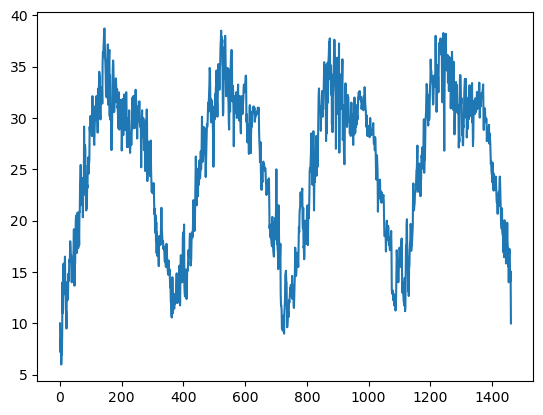

In [177]:
meantemp = train_data[ 'meantemp' ].values
plt.plot( [ i for i in range( len( meantemp ) ) ], meantemp )

In [178]:
# humidity = train_data[ 'humidity' ].values
# plt.plot( [ i for i in range( len( humidity) ) ], humidity )

In [179]:
# wind_speed = train_data[ 'wind_speed' ].values
# plt.plot( [ i for i in range( len( wind_speed) ) ], wind_speed )

In [180]:
# meanpressure = train_data[ 'meanpressure' ].values
# plt.plot( [ i for i in range( len( meanpressure) ) ], meanpressure )

In [181]:
def split( data, time_step ):                   # 数据具有很强的周期性 -> 取每12个月的数据预测后续数据
    dataX = []
    dataY = []
    for i in range( len( data ) - time_step ):
        dataX.append( data[i:i+time_step] )
        dataY.append( data[i+time_step] )
    dataX = np.array( dataX ).reshape( len( dataX ), time_step, -1 )
    dataY = np.array( dataY )
    return dataX, dataY

In [182]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
meantemp = scaler.fit_transform( meantemp.reshape( -1, 1 ) )           # 转化成二维数组后归一化，把所有数据缩小到0到1之间：加快收敛速度、提高模型性能、避免数值问题

dataX, dataY = split( meantemp, time_step = 12 )
dataX.shape, dataY.shape

((1450, 12, 1), (1450, 1))

In [183]:
def train_test_split( dataX, dataY, shuffle = False, percentage = 0.8 ):
    s_num = int( len( dataX ) * percentage )
    trainX = dataX[ : s_num ]
    trainY = dataY[ : s_num ]
    testX = dataX[ s_num : ]
    testY = dataY[ s_num : ]
    return trainX, trainY, testX, testY

In [184]:
trainX, trainY, testX, testY = train_test_split( dataX, dataY, shuffle = False, percentage = 0.8 )
X_train, Y_train = trainX, trainY

trainX.shape, trainY.shape, testX.shape , testY.shape 

((1160, 12, 1), (1160, 1), (290, 12, 1), (290, 1))

In [185]:
class CNN_LSTM( nn.Module ):
    def __init__( self, conv_input, input_size, hidden_size, layer_size, output_size ):
        super( CNN_LSTM, self ).__init__()
        self.hidden_size = hidden_size
        self.layer_size = layer_size
        self.conv = nn.Conv1d( conv_input, conv_input, 1 )          # 输入通道数，卷积深度，卷积核大小
        # lstm：输入通道数，输出通道数，隐藏层层数
        self.lstm = nn.LSTM( input_size, hidden_size, layer_size, batch_first = True )
        self.fc = nn.Linear( hidden_size, output_size )
    def forward( self, x ):
        x = self.conv( x )
        h0 = torch.zeros( self.layer_size, x.size( 0 ), self.hidden_size )
        c0 = torch.zeros( self.layer_size, x.size( 0 ), self.hidden_size )
        
        out, ( hn, cn ) = self.lstm( x, ( h0, c0 ) )
        out = self.fc( out[ :, -1, : ] )
        return out

In [186]:
testXt = torch.Tensor( testX )
testYt = torch.Tensor( testY )

input_size = 1                      # 只针对meantemp一个维度
conv_input = 12                     # 12个月卷积
hidden_size= 64
layer_size = 5
output_size = 1                     # 预测维度
batch_size = 32


model = CNN_LSTM( conv_input, input_size, hidden_size, layer_size, output_size )
loss_f = nn.MSELoss()
optimizer = optim.Adam( model.parameters(), lr = 0.01 )

for epoch in range( 500 ):
    # 每个epoch打乱训练集顺序，并只取前batch_size个内容
    random_list = [ i for i in range( len( trainX ) ) ] 
    np.random.shuffle( random_list )
    trainX = trainX[ random_list ]
    trainY = trainY[ random_list ]
    trainXt = torch.Tensor( trainX[ :batch_size ] )
    trainYt = torch.Tensor( trainY[ :batch_size ] )
    
    model.train()
    optimizer.zero_grad()
    output = model( trainXt )
    loss = loss_f( output, trainYt )
    loss.backward()
    optimizer.step()
    
    if epoch % 50 == 49: 
        model.eval()
        with torch.no_grad():
            output = model( testXt )
        test_loss = loss_f( output, testYt )
        print( '[%d] loss:%.3f' % ( epoch + 1,  test_loss ) )

[50] loss:0.034
[100] loss:0.007
[150] loss:0.005
[200] loss:0.008
[250] loss:0.003
[300] loss:0.004
[350] loss:0.004
[400] loss:0.003
[450] loss:0.003
[500] loss:0.003


检查训练的函数的好坏直接画出预测和真实的线

In [188]:
trainXt = torch.Tensor( X_train )
pred_train = model( trainXt ).detach().numpy()                          # detach() -> 从计算图中分离张量，从而不需要进行梯度计算    numpy()转换成np数组
pred_test = model( testXt ).detach().numpy()

pred = np.concatenate( ( pred_train, pred_test ) )                      # 合并
pred = scaler.inverse_transform( pred ).T[0]
# 把scaler的归一化结果还原成最开始的样子，T[0]转置后取第一列得到一个一维数组 -> 还原reshape( -1, 1 )的操作
true = np.concatenate( ( Y_train, testY ) )                             # 使用保留的还没转化成torch的数据信息
true = scaler.inverse_transform( true ).T[0]

np.mean( ( pred - true ) ** 2 )

3.533306704738696

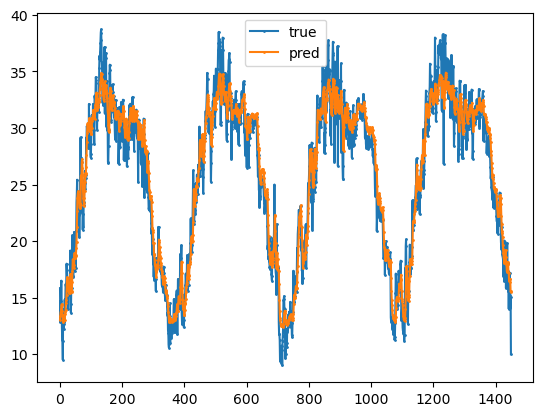

In [189]:
plt.plot( [ i for i in range( len( true ) ) ], true, marker="o",markersize=1, label = 'true' ) 
plt.plot( [ i for i in range( len( true ) ) ], pred, marker="o",markersize=1, label = 'pred')
plt.legend()
plt.show()